# Analyse der US-Präsidentschaftswahl 2016

Stellen wir uns vor, wir arbeiten als Datenwissenschaftler für eine kleine innovative Agentur. Es ist der 8. November 2016, bekommt am Nachmittag man  Medienberichte über erste Einschätzungen zu den Präsidentschaftswahlen in den USA. Ihre Agentur erhielt mehrere Aufträge von:
1. Trey Parker und Matt Stone. Sie haben ein Drehbuch für eine neue Serie von South Park zu schreiben (http://bit.ly/2eNrI1C).
2. François Hollande, der eine Gratulation für die neue Präsidentin bzw. den neuen Präsidenten vorbereiten muss (http://bit.ly/2feEfvv).

Der Chef gibt Ihnen die Aufgabe, ein Vorhersagemodell zu entwickeln und auch den wichtigsten Faktor in Landkreisen zu analysieren, in denen Donald Trump gewonnen hat. 

Es stehen 3 Datensätze zur Verfügung: county_facts.csv (Eingabevariablen), county_facts_dictionary.csv (eine Erklärung der Eingabevariablen) und pres16results.csv (Zielvariablen).
Schauen wir uns zunächst den dritten Datensatz an.

Importieren wir alle Bibliotheken, die wir dafür benötigen: pandas für Datenmanipulation und numpy für Array-Manipulation.

In [69]:
import pandas as pd
import numpy as np

Wir importieren unseren Datensatz und drucken 10 erste Zeilen davon aus:

In [122]:
pres_results_dirty = pd.read_csv("2016-us-election/pres16results.csv")
print(pres_results_dirty.head())

  county fips             cand  st  pct_report       votes  total_votes  \
0    NaN   US     Donald Trump  US      0.9951  60350241.0  127592176.0   
1    NaN   US  Hillary Clinton  US      0.9951  60981118.0  127592176.0   
2    NaN   US     Gary Johnson  US      0.9951   4164589.0  127592176.0   
3    NaN   US       Jill Stein  US      0.9951   1255968.0  127592176.0   
4    NaN   US    Evan McMullin  US      0.9951    451636.0  127592176.0   

        pct          lead  
0  0.472993  Donald Trump  
1  0.477938  Donald Trump  
2  0.032640  Donald Trump  
3  0.009844  Donald Trump  
4  0.003540  Donald Trump  


Der erhaltene Dataframe ist für unsere Aufgabe ungeeignet: 
1. Er hat viele Spalten mit unnötigen (total_votes) und/oder redundanten (fips -> county + st) Informationen.
2. Die Zeilen zeigen das Ergebnis jedes Kandidaten in jedem Landkreis, Staat und in ganzem Land. Das ist keine passende Instanz für unsere Aufgabe, wir brauchen nur Lead-Kandidat in jedem Landkreis.
3. Wir planen, fips-Wert als Index zu verwenden, aber es nimmt einige nicht-numerische Werte. Deshalb hat es einen Objekttyp (komplexer Typ
)
4. Es scheint auch, dass es eine Anzahl leerer Zellen gibt (NaN, 'not a number').

Werfen wir einen Blick auf eine Anzahl von NaN-Zellen:

In [123]:
print(pres_results_dirty.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18475 entries, 0 to 18474
Data columns (total 9 columns):
county         18131 non-null object
fips           18475 non-null object
cand           18351 non-null object
st             18351 non-null object
pct_report     18351 non-null float64
votes          18351 non-null float64
total_votes    18351 non-null float64
pct            18351 non-null float64
lead           18351 non-null object
dtypes: float64(4), object(5)
memory usage: 1.3+ MB
None


Lass uns zuerst unnötige Spalten loswerden:

In [124]:
pres_results_clean = pres_results_dirty.drop(["county", "cand",
                                              "st", "pct_report", "votes",
                                              "total_votes", "pct"],
                                             axis = 1)

Wir können einfach alle nichtnumerischen Werte von fips verwerfen. Sie bleiben entweder für einen Staat oder für das ganze Land.

In [125]:
pres_results_clean = pres_results_clean[pres_results_clean.fips.apply
                                        (lambda x: x.isnumeric())]

fips-Spalte enthält einige doppelte Werte.  Und wir wollen keine Duplikate im Index des Dateframes.

In [126]:
pres_results = pres_results_clean.drop_duplicates(subset='fips',
                                                  keep='last')

Konvertieren wir unsere fips-Spalte in Int:

In [131]:
pres_results['fips'] = pres_results['fips'].apply(pd.to_numeric,
                                                  errors='coerce')

print(pres_results.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3237 entries, 163 to 18474
Data columns (total 2 columns):
fips    3237 non-null int64
lead    3113 non-null object
dtypes: int64(1), object(1)
memory usage: 75.9+ KB
None


fips-Spalte enthält jetzt nur noch Integer-Werte, deshalb können wir sie als Index setzen:

In [83]:
pres_results.set_index('fips', inplace=True)

Unser Frame ist fast sauber, lass ihn sehen:

In [84]:
print(pres_results.head())

                  lead
fips                  
6037   Hillary Clinton
17031  Hillary Clinton
48201  Hillary Clinton
4013      Donald Trump
12086  Hillary Clinton


In [85]:
print(pres_results.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3237 entries, 6037 to 78030
Data columns (total 1 columns):
lead    3113 non-null object
dtypes: object(1)
memory usage: 50.6+ KB
None


Hm... Wir haben einige unbekannte Werte in der' lead'-Spalte. Vielleicht sind Berichte über diese Landkreise noch nicht vorbereitet. Also sei es die Aufgabe für unser Vorhersagemodell, wir müssen diese Daten in einem anderen Frame trennen:

In [86]:
pres_results_unknown = pres_results[pres_results["lead"].isnull()]
print(pres_results_unknown.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 2013 to 78030
Data columns (total 1 columns):
lead    0 non-null object
dtypes: object(1)
memory usage: 1.9+ KB
None


Jetzt können wir die unbekannten Daten mit gutem Gewissen löschen:

In [132]:
pres_results.dropna(how='any', inplace=True)

Jetzt wenden wir uns dem Klassifizierungsproblem zu: alle Landkreise, in denen Trump gewonnen hat, gehören zur Klasse 1, alle anderen - zu 0. Diese Werte speichern wir in einer Spalte 'trump_won'. In der Spalte 'Lead' gibt es keine Notwendigkeit mehr.

In [133]:
pres_results['trump_won'] = [int(row['lead'] == 'Donald Trump')
                             for index, row in pres_results.iterrows()]
pres_results.drop('lead', axis = 1, inplace=True)

In [89]:
print(pres_results.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3113 entries, 6037 to 48301
Data columns (total 1 columns):
trump_won    3113 non-null int64
dtypes: int64(1)
memory usage: 48.6 KB
None


Unser Frame ist endlich sauber.

Überprüfen wir den 1. Datensatz:

In [90]:
county_facts = pd.read_csv("2016-us-election/county_facts.csv")
print(county_facts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 54 columns):
fips                  3195 non-null int64
area_name             3195 non-null object
state_abbreviation    3143 non-null object
PST045214             3195 non-null int64
PST040210             3195 non-null int64
PST120214             3195 non-null float64
POP010210             3195 non-null int64
AGE135214             3195 non-null float64
AGE295214             3195 non-null float64
AGE775214             3195 non-null float64
SEX255214             3195 non-null float64
RHI125214             3195 non-null float64
RHI225214             3195 non-null float64
RHI325214             3195 non-null float64
RHI425214             3195 non-null float64
RHI525214             3195 non-null float64
RHI625214             3195 non-null float64
RHI725214             3195 non-null float64
RHI825214             3195 non-null float64
POP715213             3195 non-null float64
POP645213             3

Sieht viel besser aus :) Schmeissen wir unnötige Attributen weg. Wir löschen auch die Zeile mit dem fips-Wert 0 (ganze USA) und setzen die Spalte als Index.

In [91]:
county_facts_clean = county_facts.drop(["area_name", "state_abbreviation"],
                                       axis = 1)

county_facts_clean.drop(county_facts_clean["fips"] == 0, inplace=True)

county_facts_clean.set_index("fips", inplace=True)
print(county_facts_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3193 entries, 1001 to 56045
Data columns (total 51 columns):
PST045214    3193 non-null int64
PST040210    3193 non-null int64
PST120214    3193 non-null float64
POP010210    3193 non-null int64
AGE135214    3193 non-null float64
AGE295214    3193 non-null float64
AGE775214    3193 non-null float64
SEX255214    3193 non-null float64
RHI125214    3193 non-null float64
RHI225214    3193 non-null float64
RHI325214    3193 non-null float64
RHI425214    3193 non-null float64
RHI525214    3193 non-null float64
RHI625214    3193 non-null float64
RHI725214    3193 non-null float64
RHI825214    3193 non-null float64
POP715213    3193 non-null float64
POP645213    3193 non-null float64
POP815213    3193 non-null float64
EDU635213    3193 non-null float64
EDU685213    3193 non-null float64
VET605213    3193 non-null int64
LFE305213    3193 non-null float64
HSG010214    3193 non-null int64
HSG445213    3193 non-null float64
HSG096213    3193 non-nu

Schauen wir uns diese Daten an:

In [92]:
print(county_facts_clean.head())

      PST045214  PST040210  PST120214  POP010210  AGE135214  AGE295214  \
fips                                                                     
1001      55395      54571        1.5      54571        6.0       25.2   
1003     200111     182265        9.8     182265        5.6       22.2   
1005      26887      27457       -2.1      27457        5.7       21.2   
1007      22506      22919       -1.8      22915        5.3       21.0   
1009      57719      57322        0.7      57322        6.1       23.6   

      AGE775214  SEX255214  RHI125214  RHI225214    ...      SBO415207  \
fips                                                ...                  
1001       13.8       51.4       77.9       18.7    ...            0.7   
1003       18.7       51.2       87.1        9.6    ...            1.3   
1005       16.5       46.6       50.2       47.6    ...            0.0   
1007       14.8       45.9       76.3       22.1    ...            0.0   
1009       17.0       50.5       96.0

Nun müssen wir zwei Dataframes zusammenführen. Wir wählen 'inner', um den Schnitt von Zeilen zu erhalten:

In [93]:
df = pd.merge(county_facts_clean, pres_results, how='inner',
              left_index=True, right_index=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 1001 to 56045
Data columns (total 52 columns):
PST045214    3112 non-null int64
PST040210    3112 non-null int64
PST120214    3112 non-null float64
POP010210    3112 non-null int64
AGE135214    3112 non-null float64
AGE295214    3112 non-null float64
AGE775214    3112 non-null float64
SEX255214    3112 non-null float64
RHI125214    3112 non-null float64
RHI225214    3112 non-null float64
RHI325214    3112 non-null float64
RHI425214    3112 non-null float64
RHI525214    3112 non-null float64
RHI625214    3112 non-null float64
RHI725214    3112 non-null float64
RHI825214    3112 non-null float64
POP715213    3112 non-null float64
POP645213    3112 non-null float64
POP815213    3112 non-null float64
EDU635213    3112 non-null float64
EDU685213    3112 non-null float64
VET605213    3112 non-null int64
LFE305213    3112 non-null float64
HSG010214    3112 non-null int64
HSG445213    3112 non-null float64
HSG096213    3112 non-nu

Sehen wir uns das Verhältnis der Landkreisen an, in denen Trump gewonnen hat und nicht:

In [94]:
print(df[df['trump_won'] == 0]['PST045214'].count())
print(df[df['trump_won'] == 1]['PST045214'].count())

486
2626


Die Aufgabe ist nicht ausgewogen, aber wir werden unser Bestes tun.

Wir teilen unseren Rahmen in zwei Bereiche auf: Merkmale (features) und Ziel (target). Danach müssen wir die in Train- und Testsplits aufteilen:

In [95]:
from sklearn.model_selection import train_test_split

features = df.drop(pres_results.columns, axis = 1)
target = df.drop(county_facts_clean.columns, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,test_size=0.33,
                                                    random_state = 42)

Sehen wir uns das Verhältnis der Landkreisen von Klasse 0 noch an:

In [68]:
print(y_train[y_train['trump_won'] == 0].count())
print(y_test[y_test['trump_won'] == 0].count())

trump_won    333
dtype: int64
trump_won    153
dtype: int64


Sie sind auch fast im Verhältnis 7:3 geteilt.

Dann nehmen wir die Gewichte der Eingabevariablen heraus. Je größes Gewicht die Variable hat, desto wichtiger (mehr korreliert) ist sie für die Klassifikation.

Lass uns zunächst sehr beliebten RandomForestClassifier (Menge der Entscheidungsbaeumen) überprüfen. Wir werden auch Hyperparametertuning (Suche der besten Parameter für einen Algorithmus) mit GridSearchCV durchführen. RandomForestClassifier hat zwei Parameter, die wir tunen können: Anzahl der Schätzer (Bäume) und die minimale Anzahl der Samples, die für die Aufteilung eines internen Knotens erforderlich sind. 

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

# Initialisierung des Klassifikators. Mit dem Parameter' random_state'
#können wir die gleichen Berechnungen später wiederholen
rfc = RandomForestClassifier(random_state = 42)
# Das Raster der Parameter, die wir optimieren wollen
parameters = {'n_estimators': np.arange(10, 50, 5),
              'min_samples_split': np.arange(2, 10, 1)}
# wir verwenden GridSearchCV als Wrapper für unseren Klassifikator
cls = GridSearchCV(rfc, parameters)
# Modellausstattung mit Trainingdaten
cls.fit(X_train, y_train["trump_won"])
# Trainingsergebnisse drucken
print(cls.cv_results_["mean_test_score"])

[ 0.91366906  0.92230216  0.92565947  0.92613909  0.92997602  0.92853717
  0.92997602  0.93045564  0.92038369  0.92470024  0.92805755  0.93045564
  0.9323741   0.93429257  0.93477218  0.93429257  0.92326139  0.92853717
  0.92997602  0.93189448  0.93141487  0.93093525  0.93189448  0.93141487
  0.92230216  0.93189448  0.93093525  0.93141487  0.92997602  0.92997602
  0.92997602  0.9294964   0.92422062  0.92757794  0.93189448  0.92901679
  0.93093525  0.92997602  0.9323741   0.93189448  0.92470024  0.92661871
  0.92661871  0.92901679  0.9294964   0.92997602  0.92805755  0.9294964
  0.91990408  0.92613909  0.92805755  0.92709832  0.93093525  0.93093525
  0.93093525  0.93141487  0.92230216  0.92997602  0.92997602  0.9323741
  0.9323741   0.92997602  0.93045564  0.93045564]


Also machen wir Vorhersagen auf dem Testsatz und überprüfen das f1-Score: (2 x precision x recall) / (precision + recall), wo precision = TP / (TP + FP); recall = TP / (TP + FN).

In [55]:
predictions = cls.predict(X_test)
print(f1_score(y_test, predictions))

0.968696642003


Unser Algorithmus hat f1-Ergebnis ~0.97. Mal sehen, ob wir es besser machen können. Wir können einen einfacheren KNeighborsClassifier ausprobieren. Er vergibt ein Klassenlabel basierend auf benachbarten Instanzen. Die Parameter, die wir optimieren können, sind:
1. Eine Reihe von Nachbarn zu überprüfen.
2. Ein Algorithmus:' brute' wird eine Brute-Force-Suche verwenden;' ball_tree' wird BallTree (1) verwenden;' kd_tree' wird KDTree (2) verwenden;' auto' wird versuchen, den am besten geeigneten Algorithmus basierend auf den an die Methode angepassten Werten zu bestimmen.

(1) Ein Kugelbaum ist ein binärer Baum, in dem jeder Knoten eine D-dimensionale Hypersphäre oder Kugel definiert, die eine Teilmenge der zu durchsuchenden Punkte enthält.

(2) Ein k-d-Baum ist ein unbalancierter Suchbaum zur Speicherung von Punkten aus dem D-Demension

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()

parameters = {'n_neighbors': np.arange(5, 50, 5),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

cls2 = GridSearchCV(knc, parameters)

cls2.fit(X_train, y_train["trump_won"])

print(cls2.cv_results_["mean_test_score"])

[ 0.85851319  0.86378897  0.86858513  0.86906475  0.86570743  0.86570743
  0.8647482   0.86618705  0.86810552  0.85851319  0.86378897  0.86858513
  0.86906475  0.86570743  0.86570743  0.8647482   0.86618705  0.86810552
  0.85851319  0.86378897  0.86858513  0.86906475  0.86570743  0.86570743
  0.8647482   0.86618705  0.86810552  0.85851319  0.86378897  0.86858513
  0.86906475  0.86570743  0.86570743  0.8647482   0.86618705  0.86810552]


In [22]:
predictions2 = cls2.predict(X_test)
print(f1_score(y_test, predictions2))

0.929501084599


Der Klassifikator hat schlechtere Ergebnisse als der Erste. Überprüfen wir den AdaBoostClassifier. AdaBoostClassifier ist ein Meta-Schätzer, der mit dem Einpassen eines Klassifikators auf den ursprünglichen Datensatz beginnt und dann zusätzliche Kopien des Klassifikators auf den gleichen Datensatz anlegt, wobei die Gewichte falsch klassifizierter Instanzen so angepasst werden, dass nachfolgende Klassifikatoren sich mehr auf schwierige Fälle konzentrieren. AdaBoostClassifier verwendet auch Entscheidungsbäume. AdaBoostClassifier hat zwei Parameter, die wir tunen können: Anzahl der Schätzer (Bäume) und das Lerntempo, das den Beitrag jedes Klassifikators schrumpft.

In [23]:
from sklearn.ensemble import AdaBoostClassifier


abc = AdaBoostClassifier(random_state = 42)

parameters = {'n_estimators': np.arange(50, 100, 10),
              'learning_rate': np.arange(0.5, 1.5, 0.1)}

cls3 = GridSearchCV(abc, parameters)

cls3.fit(X_train, y_train["trump_won"])

print(cls3.cv_results_["mean_test_score"])

[ 0.93189448  0.93333333  0.93141487  0.93333333  0.9352518   0.9381295
  0.93093525  0.93477218  0.93573141  0.93573141  0.93956835  0.93429257
  0.93477218  0.93573141  0.9352518   0.93141487  0.92757794  0.92997602
  0.93333333  0.93285372  0.93189448  0.93189448  0.92805755  0.9294964
  0.93093525  0.92901679  0.93045564  0.92901679  0.92470024  0.92901679
  0.93381295  0.92853717  0.9323741   0.9323741   0.9323741   0.93477218
  0.93333333  0.93285372  0.93381295  0.93093525  0.92757794  0.92757794
  0.92661871  0.92182254  0.91990408  0.92997602  0.92997602  0.92853717
  0.92709832  0.92565947]


In [96]:
predictions3 = cls3.predict(X_test)
print(f1_score(y_test, predictions3))

0.968


Der Klassifikator hat dasselbe Ergebnisse als der Erste. Dann können wir GradientBoostingClassifier überprüfen. GradientBoostingClassifier baut ein additives Modell vorwärts gerichtet auf und ermöglicht die Optimierung beliebiger differenzierbarer Verlustfunktionen. In jedem Stadium werden n_classes_ Regressionsbäume auf den negativen Gradienten der binomialen oder multinomialen Deviation-Loss-Funktion angepasst. Die binäre Klassifikation (unser Fall) ist ein Sonderfall, bei dem nur ein einziger Regressionsbaum induziert wird. Der hat drei Parameter zur Feineinstellung: n_estimators, learning_rate, min_samples_split (siehe oben).

In [45]:
from sklearn.ensemble import GradientBoostingClassifier


gbc = GradientBoostingClassifier(random_state = 42)

parameters = {'n_estimators': np.arange(50, 100, 10),
              'learning_rate': np.arange(0.5, 1.5, 0.1),
              'min_samples_split': np.arange(2, 10, 1)}

cls4 = GridSearchCV(gbc, parameters)

cls4.fit(X_train, y_train["trump_won"])

print(cls4.cv_results_["mean_test_score"])

[ 0.93141487  0.92853717  0.93093525  0.9323741   0.93093525  0.93621103
  0.93429257  0.93621103  0.93573141  0.9323741   0.93333333  0.93429257
  0.9323741   0.9323741   0.93285372  0.93477218  0.9323741   0.93141487
  0.93429257  0.93333333  0.93285372  0.93141487  0.93333333  0.9323741
  0.93429257  0.93093525  0.93285372  0.93381295  0.9352518   0.93860911
  0.93333333  0.9323741   0.93141487  0.93141487  0.93764988  0.93381295
  0.93573141  0.9352518   0.93669065  0.93285372  0.92805755  0.93381295
  0.93477218  0.9323741   0.93333333  0.92613909  0.92805755  0.92853717
  0.93141487  0.9323741   0.93045564  0.93093525  0.93381295  0.93189448
  0.93189448  0.92853717  0.92613909  0.92757794  0.92709832  0.93093525
  0.9323741   0.9323741   0.93285372  0.93285372  0.93333333  0.92661871
  0.93093525  0.93189448  0.93381295  0.93189448  0.93141487  0.9323741
  0.93381295  0.93477218  0.93141487  0.93045564  0.9294964   0.93189448
  0.93381295  0.93573141  0.91798561  0.92086331  0.9

In [48]:
predictions4 = cls4.predict(X_test)
print(f1_score(y_test, predictions4))

0.9669327252


Der erste Klassifikator scheint keinen Konkurrenten zu haben. Zuletzt wird der MLPC-Klassierer (Multilayer Perzeptron Classifier) überprüft. Er ist eine Art neuronales Netz und hat folgende Parameter, um zu optimieren:

1. 'alpha' — L2-Strafe (Regularizer).
2. 'learning_rate' — 'constant' oder 'adaptive' (1).
3. 'solver' — Der Löser zur Gewichtsoptimierung.
4. 'hidden_layer_sizes' — der stellt die Anzahl der Neuronen in jeder ausgeblendeten Schicht dar.

(1) Es hält die Lernrate auf "learning_rate_init" konstant, solange der Trainingsverlust sinkt. Jedes Mal, wenn zwei aufeinanderfolgende Epochen den Trainingsverlust nicht um mindestens die Optimierungstoleranz verringern oder den Validierungswert nicht um mindestens die Optimierungstoleranz erhöhen, wenn "early_stopping" eingeschaltet ist, wird die aktuelle Lernrate durch 5 geteilt.).

In [118]:
from sklearn.neural_network import MLPClassifier


mlpc = MLPClassifier(random_state = 42)

parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1],
              'learning_rate': ['constant', 'adaptive'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'hidden_layer_sizes': [(100,), (1000,), (100,100), (1000,1000)]}

cls5 = GridSearchCV(mlpc, parameters)

cls5.fit(X_train, y_train["trump_won"])

print(cls5.cv_results_["mean_test_score"])

[ 0.641247    0.841247    0.74724221  0.641247    0.841247    0.74724221
  0.76546763  0.841247    0.82925659  0.76546763  0.841247    0.82925659
  0.3558753   0.84076739  0.81582734  0.3558753   0.84076739  0.81582734
  0.52374101  0.84076739  0.73093525  0.52374101  0.84076739  0.73093525
  0.641247    0.841247    0.74724221  0.641247    0.841247    0.74724221
  0.76546763  0.841247    0.82829736  0.76546763  0.841247    0.82829736
  0.3558753   0.84076739  0.78705036  0.3558753   0.84076739  0.78705036
  0.52374101  0.84076739  0.70503597  0.52374101  0.84076739  0.70503597
  0.641247    0.841247    0.77314149  0.641247    0.841247    0.77314149
  0.76546763  0.841247    0.82733813  0.76546763  0.841247    0.82733813
  0.3558753   0.84076739  0.81342926  0.3558753   0.84076739  0.81342926
  0.52374101  0.84076739  0.78752998  0.52374101  0.84076739  0.78752998
  0.641247    0.841247    0.77122302  0.641247    0.841247    0.77122302
  0.76546763  0.841247    0.81678657  0.76546763  0

In [119]:
predictions5 = cls5.predict(X_test)
print(f1_score(y_test, predictions5))

0.920316622691


Keiner der Klassifikatoren hat den RandomForestClassifier überwunden. Aber vielleicht wird es besser, den Sieg von Trump für jede Landkreis zu vergeben?

In [59]:
fake_predictions = np.ones(predictions.shape)
print(f1_score(y_test, fake_predictions))

0.919516044187


Das Ergebnis ist schlechter, aber nicht viel schlechter.

Schauen wir uns das Ergebnis der Klassifizierung genauer an.

In [54]:
from sklearn.metrics import classification_report

target_names = ['Trump lost', 'Trump won']
print(classification_report(y_test, predictions, target_names=target_names))

             precision    recall  f1-score   support

 Trump lost       0.84      0.79      0.81       153
  Trump won       0.96      0.97      0.97       874

avg / total       0.95      0.95      0.95      1027



Die Genauigkeit in der Klasse 0 (Trump hat verloren) ist viel kleiner als in der Klasse 1 (Trump hat gewonnen). Es geschieht, weil die Klassen nicht ausgeglichen sind, haben wir weniger Beispiele für seine Niederlage. Trotzdem sind die Ergebnisse nicht schlecht.

Als nächstes überprüfen wir die Importwerte der Merkmalen:

In [18]:
print(cls.best_estimator_.feature_importances_)
index_max = cls.best_estimator_.feature_importances_.argmax()
most_important = df.columns[index_max]
print(index_max)
print(most_important)

Die wichtigste Variable is die 9. mit dem Gewicht ~ 0.1. Die Variable ist der Prozentsatz von ledigen weissen Amerikaner.

[ 0.01316113  0.007436    0.00932391  0.01747339  0.01233124  0.0170514
  0.00795777  0.00793931  0.08139678  0.05059575  0.00849444  0.01977642
  0.00273796  0.00921944  0.01985473  0.0978463   0.01107737  0.01218805
  0.01725632  0.01231555  0.05711583  0.00627506  0.0090577   0.01683615
  0.02593444  0.04400118  0.03750532  0.01321546  0.01493427  0.00960399
  0.01364165  0.0228313   0.02254996  0.03632903  0.00669436  0.02121852
  0.01083342  0.01890404  0.00529295  0.01263846  0.00160237  0.01009489
  0.01884705  0.00800651  0.0057925   0.0161497   0.00691778  0.0436535
  0.00775931  0.01131954  0.02901048]
15
RHI825214


Das wichtigste Feature ist das 16. mit dem Gewicht von ~0,09. Die Korrelation ist sehr schwach, so dass das Merkmal selbst unsere Klassifikation nicht erklären kann. Schauen wir mal, was dieses Feature bedeutet: 

In [101]:
definition = pd.read_csv("2016-us-election/county_facts_dictionary.csv")
mid = definition[definition['column_name'] == most_important]
      ['description']
print(mid)

15    White alone, not Hispanic or Latino, percent, ...
Name: description, dtype: object


Das Feature zeigt den Prozentsatz von ledigen weißen Amerikaner (ohne lateinamerikanische Herkunft).

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

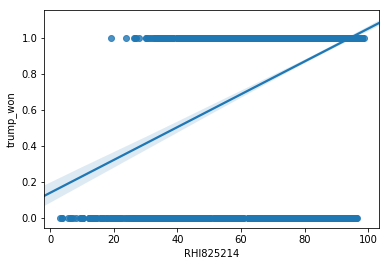

In [19]:
fif = sns.regplot(x=most_important, y="trump_won", data=df,
            label='Most important feature')
fif.set(xlabel=mid, ylabel='Trump won')
plt.show()

Hier ist das 2. wichtigste Feature: der Prozentsatz von ledigen weissen Amerikaner.

8    White alone, percent, 2014
Name: description, dtype: object


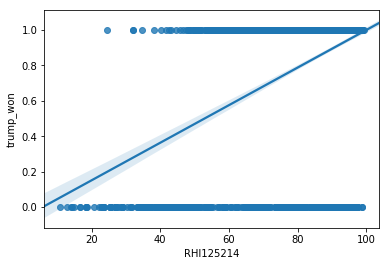

In [102]:
second_important = df.columns[8]
sid = definition[definition['column_name'] == second_important]
      ['description']
print(sid)
sns.regplot(x=second_important, y="trump_won", data=df
            , label='Second important feature')
fif.set(xlabel=sid, ylabel='Trump won')
plt.show()

Wie wir sehen können, gibt es kein bestimmtes Feature, das das Ergebnis von Trump erklären kann. Aber die Kombination von Merkmalen kann eine gute Klassifizierung ermöglichen, weil jedes seinen Beitrag leistet.

So die Autoren von "South Park" sind bereits zufrieden mit unserem Ergebnis, aber der Präsident von Frankreich ist nicht. Er fragt, ob wir für unsere Schätzung ein 95%-Konfidenzintervall aufbauen können. Also zurück an die Arbeit. Wir werden eine Kreuzvalidierung für unseren besten Klassifikator durchführen. Damit können wir die unvoreingenommene Schätzung auf den gesamten markierten Datensatz berechnen. Wir verwenden f1-Score für die Kreuzvalidierung.

In [111]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(cls, features, target['trump_won'], cv=10,
                         scoring='f1')
print(scores)

[ 0.94509804  0.95895522  0.98484848  0.96641791  0.97185741  0.95274102
  0.96045198  0.971537    0.95038168  0.94972067]


In [120]:
print("Genauigkeit: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Genauigkeit: 0.961 (+/- 0.024)


Jetzt müssen wir einen Dataframe vorbereiten, um unsere Vorhersage auf nicht markierten Datensätzen zu machen

In [114]:
df_pred = pd.merge(county_facts_clean, pres_results_unknown, how='inner',
              left_index=True, right_index=True)
df_pred.drop('lead', axis=1, inplace=True)
print(df_pred.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 2013 to 51515
Data columns (total 51 columns):
PST045214    32 non-null int64
PST040210    32 non-null int64
PST120214    32 non-null float64
POP010210    32 non-null int64
AGE135214    32 non-null float64
AGE295214    32 non-null float64
AGE775214    32 non-null float64
SEX255214    32 non-null float64
RHI125214    32 non-null float64
RHI225214    32 non-null float64
RHI325214    32 non-null float64
RHI425214    32 non-null float64
RHI525214    32 non-null float64
RHI625214    32 non-null float64
RHI725214    32 non-null float64
RHI825214    32 non-null float64
POP715213    32 non-null float64
POP645213    32 non-null float64
POP815213    32 non-null float64
EDU635213    32 non-null float64
EDU685213    32 non-null float64
VET605213    32 non-null int64
LFE305213    32 non-null float64
HSG010214    32 non-null int64
HSG445213    32 non-null float64
HSG096213    32 non-null float64
HSG495213    32 non-null int64
HSD410213   

Es gibt nur Informationen über 32 Landkreise. Lassen wir unser Modell funktionieren:

In [116]:
results_pred = cls.predict(df_pred)
print(results_pred)

[1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0]


Wir müssen die Vorhersagen in csv-Datei schreiben.

In [117]:
predictions_df = pd.DataFrame()
predictions_df['fips'] = df_pred.index
predictions_df['trump_win'] = results_pred
predictions_df.to_csv('./result.csv', index=False)

Dieses csv-Dokument mit dem Vertrauensintervall für die Genauigkeit kann an unsere Kunden geschickt werden.

#### Fazit: In unserem kleinen Wettbewerb hat der RandomForestClassifier gewonnen. Kein Wunder, er ist einfach, aber sehr leistungsfähig und populär Klassifikator, stabil zu redundanten und unskalierten Merkmalen.

Ideen zur weiteren Verbesserung:
in RandomForestClassifier, wenn zwei Merkmale hochgradig korreliert sind (eines davon ist redundant), nimmt der Algorithmus eines davon (keine Präferenz). Die Bedeutung des zweiten Features wird dann reduziert. Es hat keinen Einfluss auf die Genauigkeit des Algorithmus, sondern verursacht ein Problem bei der Interpretation des Ergebnisses: das erste Feature wird als starker Prädiktor betrachtet, das andere als unwichtig, während es in Bezug auf seine Beziehung zum Ziel eigentlich sehr eng ist. Eine weitere Analyse von Merkmalsvariablen ist erforderlich.